In [1]:
from os import listdir
from os.path import isfile, join
import re

import numpy as np
import pandas as pd

init_path = 'csv_dialogs'
processed_path = 'csv_processed_dialogs'

group_ids = [int(re.split('\.', f)[0]) for f in listdir(init_path) if isfile(join(init_path, f)) and re.match('\d+\.csv', f) is not None]
group_ids = [145254340]

In [3]:
group_data_list = []
for group_id in group_ids:
    group_data = pd.read_csv(join(init_path, '{}.csv'.format(group_id)))
    group_data_list.append(group_data)
    
group_data = pd.concat(group_data_list)
group_data.head()

,user_id,dialog_number,message_number,text,is_income
0,402472964,0,0,Собеседник: \nПриветствую,1
1,402472964,0,1,Собеседник: \nЗдрастееэээ?,1
2,402472964,0,2,Собеседник: \nЭм...,1
3,402472964,0,3,Собеседник: \nМммм...,1
4,402472964,0,4,Собеседник: \nТы на связи?,1


In [121]:
# group_data.set_index('user_id', 'dialog_number', 'message_number')
# group_data.head()
group_data.shape

(745320, 5)

In [ ]:
groups_dialogs_top = group_data.groupby('user_id').agg({'dialog_number': lambda x: np.max(x) + 1, 'group_id': np.max})

In [57]:
group_data.query('user_id == 386898798 and dialog_number == 71').to_csv('very_big_dialog.csv')

In [65]:
# dialog_length = np.empty(36165, dtype=np.int32)
# i = 0
# for user_id in group_data['user_id'].unique():
#     dialog_numbers = group_data[group_data['user_id'] == user_id]['dialog_number'].unique()
#     for dialog_number in dialog_numbers:
#         one_dialog_messages = group_data.query('user_id == {} and dialog_number == {}'.format(user_id, dialog_number))
#         dialog_length[i] = len(one_dialog_messages)
#         i += 1
# #         break
# #     break
# one_dialog_messages.head()
group_by_dialog_size = group_data.groupby(('user_id', 'dialog_number'))
agg_dialogs = group_by_dialog_size.agg({'message_number': lambda x: np.max(x) + 1})

s_agg_dialogs = agg_dialogs.sort_values('message_number', ascending=False).reset_index()



In [60]:
count_mes_more_than = []
for i in xrange(10, 1000):
    res = group_by_dialog_size.sort_values('message_number', ascending=False).reset_index().query('message_number > {}'.format(i)).shape[0]
    count_mes_more_than.append(res)
# group_by_dialog_size.reset_index().head()

In [97]:
# good dialogs
# 7146 elems
# half_mn = 27
# 7127 : 7465
# s_agg_dialogs[:np.int(s_agg_dialogs.shape[0] * 0.2)]
good_dialogs = s_agg_dialogs.query('message_number > 27')
good_dialogs.to_csv('good_dialogs.csv', index=None)

In [134]:
# bad dialogs
group_data.query('user_id == {} and dialog_number == {}'.format(58212957, 1))
group_data.query('user_id == {} and dialog_number == {}'.format(415005995, 46))
group_data.query('user_id == {} and dialog_number == {}'.format(316821755, 5))
group_data.query('user_id == {} and dialog_number == {}'.format(415005995, 58))
group_data.query('user_id == {} and dialog_number == {}'.format(2486613, 21))


,user_id,dialog_number,message_number,text,is_income
577885,2486613,21,0,Собеседник: \nПривет,1
577886,2486613,21,1,Лол,0
577887,2486613,21,2,Привет,0


In [135]:
# message_number > 3 change to income message > 1
bad_dialogs = s_agg_dialogs[- np.int(s_agg_dialogs.shape[0] * 0.2) :].query('dialog_number > 3 and message_number > 3')
# bad_dialogs.loc[:, ('user_id', 'dialog_number')].to_csv('bad_dialogs.csv', index=None)
indexed_bad_dialogs = s_agg_dialogs[- np.int(s_agg_dialogs.shape[0] * 0.2) :].query('dialog_number > 3').rename(columns={'message_number': 'messages_count'}).set_index(['user_id', 'dialog_number'])
indexed_bad_dialogs['score'] = -1
indexed_bad_dialogs
indexed_group_data = group_data.set_index(['user_id', 'dialog_number'])
true_bad_dialogs = indexed_group_data.join(indexed_bad_dialogs).query('score == -1 and is_income == 1').reset_index().loc[:, ['user_id', 'dialog_number']]
true_bad_dialogs.head()
true_bad_dialogs.to_csv('bad_dialogs.csv', index=None)


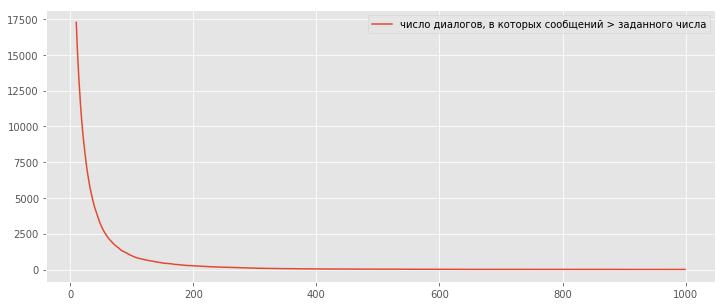

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

plt.plot(xrange(10, 1000), count_mes_more_than, label=u'число диалогов, в которых сообщений > заданного числа')
plt.legend()
# plt.xscale('log')


In [49]:
group_by_dialog_size.sort_values('message_number', ascending=False).reset_index().sort_values('dialog_number', ascending=False).head()

,user_id,dialog_number,message_number
33968,422045523,742,2
20574,422045523,741,8
27706,422045523,740,4
31467,422045523,739,3
18212,422045523,738,10


In [38]:
indexed_group_data = group_data.set_index(['user_id', 'dialog_number'])
# for val in indexed_group_data:
#     print val
#     break
indexed_group_data['message_number'][indexed_group_data['message_number'] == max(indexed_group_data['message_number'])]

user_id    dialog_number
386898798  71               1813
Name: message_number, dtype: int64

In [1]:
import nltk
import string
from nltk.corpus import stopwords
class Tokenizer:
    def __init__(self):
        stop_words = stopwords.words('russian')
        stop_words.extend([item.decode('utf-8') for item in ('что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на')])
#         self.stop_words = [unicode(item) for item in stop_words]
        stop_words.extend([item.decode('utf-8') for item in string.punctuation])
        self.stop_words = stop_words
    def tokenize(self, text):
        #firstly let's apply nltk tokenization
#         tokens = [token.decode('utf-8') for token in nltk.word_tokenize(text)]

        #let's delete punctuation symbols
#         tokens = [i for i in tokens if ( i not in string.punctuation )]

        #deleting stop_words
#         tokens = [i for i in tokens if ( i not in self.stop_words )]

        #cleaning words
    #     tokens = [i.replace("«", "").replace("»", "") for i in tokens]
        return nltk.word_tokenize(text)
#         return tokens

In [ ]:
for group_id in group_ids:
    group_data = pd.read_csv(join(init_path, '{}.csv'.format(group_id)))
    group_data.loc[:,'text'] = group_data.loc[:,'text'].str.decode('utf-8').str.lower().fillna(u'а')
    keys = group_data['is_income'] == 1
    group_data.loc[keys,'text'] = group_data[keys]['text'].str.slice(13)
    
#     group_data.to_csv(join(processed_path, '{}.csv'.format(group_id)), encoding='utf-8', index=False)
# group_data['text'].apply(tokenizer)
# tokenizer = Tokenizer()
group_data['tokens'] = group_data['text'].apply(nltk.word_tokenize)
# tokenizer = Tokenizer()
# for word in tokenizer.tokenize('как прикажете к вам обращаться?'):
#     print word

In [7]:
group_data.shape

(21, 6)

In [4]:
%time group_data['text'].apply(nltk.word_tokenize)

CPU times: user 850 µs, sys: 4.06 ms, total: 4.91 ms
Wall time: 4.46 ms


0            [оляляля]
1                [фка]
2               [стоп]
3               [стоп]
4              [sdfsd]
5                  [1]
6                   []
7                  [!]
8                  [а]
9                   []
10                  []
11                  []
12                  []
13                  []
14                  []
15                 [а]
16            [xxxxxx]
17             [yyyyy]
18    [zzzzzzzzzzzzzz]
19               [ccc]
20             [rrrrr]
Name: text, dtype: object

In [18]:
type(group_data[keys]['text'][0])

unicode

In [20]:
type(stopwords.words('russian')[0])

unicode

In [5]:
# for item in ('что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'):

stop_words = []
# stop_words = stopwords.words('russian')
stop_words.extend([item.decode('utf-8') for item in ('что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на')])
# stop_words.extend([item.decode('utf-8') for item in string.punctuation])

text = 'ну что же, кю, расскажите о себе'
tokens = nltk.word_tokenize(text)
for token in tokens:
    print type(token)
    print token
# tokens = [item for item in tokens if item not in stop_words]

<type 'str'>
ну
<type 'str'>
что
<type 'str'>
же
<type 'str'>
,
<type 'str'>
кю
<type 'str'>
,
<type 'str'>
расскажите
<type 'str'>
о
<type 'str'>
себе


In [6]:
# type(unicode('ё'))
'ё'.decode('utf-8')

u'\u0451'